In [117]:
import pandas as pd
import numpy as np
from snowflake.snowpark import Session
import snowflake.snowpark.functions as sfunc
import snowflake.snowpark.types as stypes
import plotly.graph_objects as go
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col
from plotly.subplots import make_subplots
from dotenv import load_dotenv
from matplotlib import pyplot as plt
import os
from sentence_transformers import SentenceTransformer
import plotly.graph_objects as go
from snowflake.snowpark.types import FloatType, IntegerType
from scipy import stats
import scipy.odr as odr
import plotly.figure_factory as ff
from sklearn.neighbors import KernelDensity
from scipy.stats import linregress
from tqdm import tqdm

load_dotenv()

True

# Primary EDA and Data Cleaning

In this notebook there are five parts
1. Create posting-level data
2. Posting Level EDA
3. Compositional Analysis
4. Internal Effects Analysis
5. Create company, industry, geographic data


## Create Posting-Level Data

In [6]:
# connecting to the snowflake database
connection_parameters = {
    "user": os.getenv("SNOWFLAKE_USER"),
    "password": os.getenv("SNOWFLAKE_PASSWORD"),
    "account": os.getenv("SNOWFLAKE_ACCOUNT"),
    "warehouse": os.getenv("SNOWFLAKE_WAREHOUSE"),
    "database": os.getenv("SNOWFLAKE_DATABASE"),
    "schema": os.getenv("SNOWFLAKE_SCHEMA"),
}
session = Session.builder.configs(connection_parameters).create()

In [ ]:
# country data dictionary for easy switching
choice = "US"
country = {
    "US": {
        "POSTS_TABLE": "OII_US_10M_SAMP_POSTS",
        "SKILLS_TABLE": "OII_US_10M_SAMP_SKILLS",
        "INDUSTRY": "NAICS_2022_2_NAME",
        "LOW_OCC_CODE": "ONET",
        "LOW_OCC_NAME": "ONET_NAME",
        "HIGH_OCC_NAME": "SOC_2021_2_NAME",
        "REGION": "STATE_NAME"
    }
}

### Create Skill Groups

In [8]:
# loading the sentence transformer model
model = SentenceTransformer("all-mpnet-base-v2")
# these are the names of the data tables
posts_sp = session.read.table(country[choice]["POSTS_TABLE"])
skills_sp = session.read.table(country[choice]["SKILLS_TABLE"])

In [9]:
# get universe of skills with more than 1000 postings
all_skills_df = skills_sp \
    .groupBy(["SKILL_NAME"]) \
    .agg(
         sfunc.count_distinct("ID").alias("COUNT")
    ).to_pandas()

all_skills_df.sort_values(by="COUNT", ascending=False)
all_skills = np.array(all_skills_df["SKILL_NAME"][all_skills_df["COUNT"] > 1000].tolist())
all_skills_lower = np.array([skill.lower() for skill in all_skills])

In [ ]:
# define substitute and complement skill groups
sub_groups = [
    "Summary and Reporting",
    "Language and Text Review",
    "Customer Service",
    "Office and Financial Administration"
]

comp_groups = [
    "Analytical Thinking",
    "Digital Literacy",
    "Resilience",
    "Technical Proficiency",
    "Ethics",
    "Working with Others",
    "Self-Efficiency"
]

# get the embeddings for the skills and groups
skills_encode = model.encode(all_skills_lower, show_progress_bar=True, convert_to_tensor=False)
sub_group_encode = model.encode(sub_groups, show_progress_bar=True, convert_to_tensor=False)
comp_group_encode = model.encode(comp_groups, show_progress_bar=True, convert_to_tensor=False)

# calculate the cosine similarity between the skills and the groups
sub_sims =  sub_group_encode @ skills_encode.T
comp_sims =  comp_group_encode @ skills_encode.T

del skills_encode
del sub_group_encode
del comp_group_encode

Batches:   0%|          | 0/225 [00:00<?, ?it/s]

Batches: 100%|██████████| 1/1 [00:00<00:00, 165.99it/s]


In [ ]:
# identify the top N skills for each group
top_N = 10
top_sub_skills = sub_sims.argsort(axis=1)[:, -top_N:]
top_comp_skills = comp_sims.argsort(axis=1)[:, -top_N:]

sub_skill_groups = []
for i, s in enumerate(sub_groups):
    temp_skills = all_skills[top_sub_skills[i]]
    temp_counts = all_skills_df[all_skills_df["SKILL_NAME"].isin(temp_skills)].to_dict(orient="records")
    for skill in temp_counts:
        sub_skill_groups.append({
            "GROUP": s,
            "SKILL": skill["SKILL_NAME"],
            "COUNT": skill["COUNT"]
        })
sub_skill_df = pd.DataFrame(sub_skill_groups)

comp_skill_groups = []
for i, c in enumerate(comp_groups):
    temp_skills = all_skills[top_comp_skills[i]]
    temp_counts = all_skills_df[all_skills_df["SKILL_NAME"].isin(temp_skills)].to_dict(orient="records")
    for skill in temp_counts:
        comp_skill_groups.append({
            "GROUP": c,
            "SKILL": skill["SKILL_NAME"],
            "COUNT": skill["COUNT"]
        })
comp_skill_df = pd.DataFrame(comp_skill_groups)

In [49]:
# manual review of skills to remove some that are not relevant

# substitutable skills
# remove statistical reporting
summary_report = ['Management Reporting', 'Annual Reports', 'Internal Reporting', 'Technical Report', "Auditor's Report", 'Report Writing', 'Operational Reporting', 'Business Reporting']
language_review = ['Language Arts', 'Writing Systems', 'Reviewing Applications', 'Document Review', 'English Language', 'Foreign Language', 'Language Development', 'Multilingualism', 'Written English']
customer_service = ['Customer Service', 'Customer Service Desk', 'Customer Development', 'Healthcare Customer Service', 'Sales Support', 'Client Services', 'Technical Support', 'People Services', 'Customer Support', 'Customer Service Training']
# remove financial services, accounting, and financial Management
office_admin = ['Office Management', 'Payroll Administration', 'Bookkeeping', 'Sales Administration', 'Accounting Management', 'Business Administration', 'Office Administration']
sub_skills = summary_report + language_review + customer_service + office_admin

# complementary skills
analytical_thinking = ['Problem Solving', 'Critical Thinking', 'Systems Thinking', 'Creative Thinking', 'Strategic Thinking', 'Analytical Skills', 'Intelligence Analysis', 'Independent Thinking', 'Creative Problem Solving', 'Analytical Thinking']
# remove educational technologies, literacy, health literacy
digital_literacy = ['Digital Content', 'Digital Transformation', 'Data Literacy', 'Digital Media', 'Digital Technology', 'Digital Literacy', 'Computer Literacy']
# remove resourcefulness, disaster preparedness, and healing
resilience = ['Tactfulness', 'Courage', 'Preparedness', 'Ingenuity', 'Tenacity', 'Resilience', 'Survivability']
# remove analytical skills, technical supervision, technical engineering, fine motor skills
technical_proficiency = ['Technical Training', 'Technical Engineering', 'Mechanical Aptitude', 'Technical Communication', 'Diagnostic Skills', 'Technical Acumen', 'Competency Assessment']
# remove sincerity, empathy, compassion, and accountability
ethics = ['Honesty', 'Professional Responsibility', 'Business Ethics', 'Personal Integrity', 'Ethical Standards And Conduct']
working_others = ['Interdisciplinary Collaboration', 'Teamwork', 'Delegation Skills', 'Collaborative Communications', 'Collaboration', 'Team Building', 'Team Processes', 'Cross-Functional Collaboration', 'Partner Development', 'Support Colleagues']
self_efficiency = ["Self-Awareness", "Business Efficiency", "Resourcefulness", "Operational Efficiency"]
comp_skills = analytical_thinking + digital_literacy + resilience + technical_proficiency + ethics + working_others + self_efficiency

sub_skill_df["INCLUDED"] = sub_skill_df["SKILL"].isin(sub_skills)
sub_skill_df.reset_index(inplace=True, drop=True)

comp_skill_df = comp_skill_df.reset_index(drop=True)
comp_skill_df["INCLUDED"] = comp_skill_df["SKILL"].isin(comp_skills)

display(sub_skill_df.sample(5))
display(comp_skill_df.sample(5))

,GROUP,SKILL,COUNT,INCLUDED
25,Summary and Reporting,Statistical Reporting,13314,False
50,Customer Service,Customer Service,3365338,True
40,Language and Text Review,Language Arts,1134,True
32,Prediction and Forecasting,Revenue Forecasting,10213,False
67,Office and Financial Administration,Office Administration,13814,True


,GROUP,SKILL,COUNT,INCLUDED
38,Technical Proficiency,Technical Acumen,61663,True
50,Working with Others,Interdisciplinary Collaboration,3343,True
10,Digital Literacy,Digital Content,9603,True
67,Self-Efficiency,Business Efficiency,1424,True
14,Digital Literacy,Educational Technologies,3842,False


In [ ]:
# get AI/ML skills
ai_skills_df = skills_sp.filter(
        sfunc.col("SKILL_SUBCATEGORY_NAME") == 'Artificial Intelligence and Machine Learning (AI/ML)'
    ) \
    .groupBy(
        sfunc.col("SKILL_NAME")
    ) \
    .agg(
         sfunc.count_distinct("ID").alias("COUNT")
    ).to_pandas()
    
ai_skills = ai_skills_df[~ai_skills_df["SKILL_NAME"].isin(["Machine Learning", "Artificial Intelligence"])]["SKILL_NAME"].tolist()

In [51]:
ai_skills_df["INCLUDED"] = ai_skills_df["SKILL_NAME"].isin(ai_skills)
ai_skills_df.sample(5)

,SKILL_NAME,COUNT,INCLUDED
143,Support Vector Machine,1403,True
32,Theano (Software),519,True
99,Ethical AI,133,True
137,Soft Computing,1,True
24,H2O.ai,872,True


In [52]:
skills_list = {
    "AI": ai_skills,
    "COMPLEMENT": comp_skills,
    "SUBSTITUTE": sub_skills,
    "SUMMARY_REPORT": summary_report,
    "LANGUAGE_REVIEW": language_review,
    "CUSTOMER_SERVICE": customer_service,
    "OFFICE_ADMIN": office_admin,
    "ANALYTICAL_THINKING": analytical_thinking,
    "DIGITAL_LITERACY": digital_literacy,
    "RESILIENCE": resilience,
    "TECHNICAL_PROFICIENCY": technical_proficiency,
    "ETHICS": ethics,
    "WORKING_OTHERS": working_others,
    "SELF_EFFICIENCY": self_efficiency
}

### Load Postings Data

In [ ]:
# preparing post skill composition data
def skill_composition(skills_sp, groups):
    
    select_columns = np.array([
        [
            sfunc.cast(sfunc.cast(sfunc.col("SKILL_NAME").isin(skills), IntegerType()), FloatType()).alias(f"{group}"),
            sfunc.cast(sfunc.cast(
                (
                    (~sfunc.col("SKILL_NAME").isin(skills)) &
                    (~sfunc.col("SKILL_NAME").isin(groups["AI"]))
                ),
                IntegerType()), FloatType()
            ).alias(f"NON_AI_{group}")
        ]
        for group, skills in groups.items() if group != "AI"
    ]).flatten().tolist() + [sfunc.cast(sfunc.cast(sfunc.col("SKILL_NAME").isin(groups["AI"]), IntegerType()), FloatType()).alias("AI"), sfunc.col("ID")]
    
    # we add a small value to each count to avoid errors in downstream transformations
    agg_columns = np.array([
        [
            # adding .65 to each count as the recommended value for filling zeros in compositional data
            # From: Filzmoser, Peter, Karel Hron, and Matthias Templ. "Applied compositional data analysis." Cham: Springer (2018).
            (sfunc.sum(sfunc.col(f"{group}")) + .65).alias(f"{group}_COUNT"),
            (sfunc.sum(sfunc.col(f"NON_AI_{group}")) + .65).alias(f"NON_AI_{group}_COUNT"),
            (sfunc.cast(sfunc.sum(sfunc.col(f"{group}")) > 0, IntegerType())).alias(f"{group}")
        ]
        for group, skills in groups.items() if group != "AI"
    ]).flatten().tolist() + [(sfunc.sum(sfunc.col("AI")) + .65).alias(f"AI_COUNT"), sfunc.cast(sfunc.sum(sfunc.col("AI")) > 0, IntegerType()).alias(f"AI")]
    
    return skills_sp \
        .select(select_columns) \
        .group_by(
            sfunc.col("ID")
        ) \
        .agg(agg_columns)
        
compositions_sp = skill_composition(skills_sp, skills_list)

# merge skill compositions with posts
posts_sp2 = posts_sp \
    .join(
        compositions_sp,
        posts_sp["ID"] == compositions_sp["ID"],
        how="left"
    ) \
    .with_column(
        "ID",
        posts_sp["ID"]
    )

In [ ]:
# collect the data from snowflake
skill_columns = np.array([
    [
        f"{group}_COUNT",
        f"NON_AI_{group}_COUNT",
        f"{group}"
    ]
    for group, _ in skills_list.items() if group != "AI"
]).flatten().tolist() + ["AI_COUNT", "AI"]

posts_df = posts_sp2.filter(
        (sfunc.year(sfunc.col("POSTED")).between(2018, 2023))
    ) \
    .select([
            sfunc.col("ID"),
            sfunc.col(country[choice]['REGION']),
            sfunc.col(country[choice]["INDUSTRY"]),
            sfunc.col("MIN_EDULEVELS_NAME"),
            sfunc.col("MIN_YEARS_EXPERIENCE"),
            (sfunc.col("EMPLOYMENT_TYPE") == 1).alias("FULL_TIME"),
            sfunc.col("IS_INTERNSHIP"),
            sfunc.year(sfunc.col("POSTED")).alias("YEAR"),
            sfunc.quarter(sfunc.col("POSTED")).alias("QUARTER"),
            sfunc.lower(sfunc.col("TITLE_RAW")).alias("TITLE_RAW"),
            sfunc.col(country[choice]["LOW_OCC_CODE"]),
            sfunc.col(country[choice]["LOW_OCC_NAME"]),
            sfunc.col(country[choice]["HIGH_OCC_NAME"]),
            sfunc.col("COMPANY"),
            sfunc.col("COMPANY_NAME"),
            sfunc.col("SALARY"),
            sfunc.ln(sfunc.col("SALARY") + 1).alias("LOG_SALARY"),
            sfunc.array_size(sfunc.col("SKILLS")).alias("SKILLS_COUNT"),
            sfunc.col("COMPANY_IS_STAFFING"),
            sfunc.length(sfunc.col("BODY")).alias("BODY_LENGTH")
        ] + [sfunc.col(col) for col in skill_columns]
    ) \
    .na.fill({col: 0 if "COUNT" not in col else .65 for col in skill_columns}) \
    .to_pandas()

In [17]:
posts_df.head(5)

,ID,STATE_NAME,NAICS_2022_2_NAME,MIN_EDULEVELS_NAME,MIN_YEARS_EXPERIENCE,FULL_TIME,IS_INTERNSHIP,YEAR,QUARTER,TITLE_RAW,...,NON_AI_ETHICS_COUNT,ETHICS,WORKING_OTHERS_COUNT,NON_AI_WORKING_OTHERS_COUNT,WORKING_OTHERS,SELF_EFFICIENCY_COUNT,NON_AI_SELF_EFFICIENCY_COUNT,SELF_EFFICIENCY,AI_COUNT,AI
0,11fe3234a739fba40c46f3be5622ccce6744e0d8,Colorado,Wholesale Trade,No Education Listed,1.0,True,False,2023,2,installation manager,...,21.65,0,0.65,21.65,0,0.65,21.65,0,0.65,0
1,c80f25ac0888b69869be1ae81b979f67ec97fbf2,Kentucky,Retail Trade,No Education Listed,NaN,False,False,2018,4,alterations specialist [part-time],...,10.65,0,0.65,10.65,0,0.65,10.65,0,0.65,0
2,2a105fe50d6c194acb33809aaa13d052ae0e2ed0,Washington,Health Care and Social Assistance,High school or GED,NaN,True,False,2023,2,medical assistant - occupational health (capit...,...,14.65,0,0.65,14.65,0,0.65,14.65,0,0.65,0
3,afa1f01986ee95b567a4c76dfa01e17c7ac1ba61,Georgia,Information,Bachelor's degree,4.0,True,False,2022,1,lead financial analyst planning & forecasting,...,31.65,0,0.65,31.65,0,0.65,31.65,0,0.65,0
4,8bab9baa4b2f20d10cfd3bad731e1b16c582111a,Texas,Administrative and Support and Waste Managemen...,High school or GED,NaN,True,False,2020,3,apply now! plant worker,...,6.65,0,0.65,6.65,0,0.65,6.65,0,0.65,0


## Posting-Level EDA

In [71]:
# calculate the proportion of substitutable and complementary skills for each year and AI status
proportions_df = posts_df \
    .groupby(["AI", "YEAR"]) \
    .agg({"COMPLEMENT": "mean", "SUBSTITUTE": "mean"}).reset_index()

# get median salary for AI/non-AI posts with complementary skills
complement_salaries_df = posts_df \
    .groupby(["AI", "COMPLEMENT", "YEAR"]) \
    .agg({"SALARY": "median"}).reset_index()
complement_salaries_df = complement_salaries_df[complement_salaries_df["COMPLEMENT"] == 1]

# get median salary for AI/non-AI posts with substitutable skills
substitute_salaries_df = posts_df \
    .groupby(["AI", "SUBSTITUTE", "YEAR"]) \
    .agg({"SALARY": "median"}).reset_index()
substitute_salaries_df = substitute_salaries_df[substitute_salaries_df["SUBSTITUTE"] == 1]

fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=[
        "% OJVs",
        "Median Salary ('000 USD)"
    ],
    shared_xaxes=False
)

color_map = {"COMPLEMENT": "blue", "SUBSTITUTE": "red"}
skill_types = ["COMPLEMENT", "SUBSTITUTE"]

# display the proportion of substitutable and complementary skills
for ai_val in [True, False]:
    dash_style = "dot" if ai_val else "solid"
    for skill in skill_types:
        df = proportions_df[proportions_df["AI"] == ai_val]
        fig.add_trace(
            go.Scatter(
                x=df["YEAR"],
                y=df[skill] * 100,
                mode="lines",
                name=f"{skill.title()} ({'of AI posts' if ai_val else 'of Non-AI posts'})",
                line=dict(color=color_map[skill], dash=dash_style),
                showlegend=True
            ),
            row=1, col=1
        )
  
# display the median salary for AI/non-AI posts with substitutable and complementary skills      
for ai_val in [True, False]:
    for skill in skill_types:
        df = substitute_salaries_df if skill == "SUBSTITUTE" else complement_salaries_df
        df = df[df["AI"] == ai_val]
        fig.add_trace(
            go.Scatter(
                x=df["YEAR"],
                y=df["SALARY"] / 1000,  # Convert to thousands
                mode="lines",
                line=dict(color=color_map[skill], dash="dot" if ai_val else "solid"),
                showlegend=False
            ),
            row=1, col=2
        )

fig.update_layout(
    xaxis_title="Year",
    template="plotly_white",
    xaxis_showgrid=False,
    yaxis_showgrid=False,
    yaxis_range=[0, 100],
    margin=dict(l=50, r=50, t=50, b=50),
    width=800,
    height=400,
    legend=dict(
        yanchor="top",
        y=.95,
        xanchor="left",
        x=.05
    )
)

fig.show()

fig.write_image("figures/proportions_salaries_ts.png", width=800, height=400, scale=2)

In [72]:
mean_ai_posts = posts_df["AI"].mean()
print(f"Proportion of AI posts in Total: {mean_ai_posts:.2%}")

Proportion of AI posts in Total: 0.45%


In [73]:
# create odds ratio time series
yearly_df = posts_df.groupby(["YEAR", "AI"]).agg({
    "SUMMARY_REPORT": "mean",
    "LANGUAGE_REVIEW": "mean",
    "CUSTOMER_SERVICE": "mean",
    "OFFICE_ADMIN": "mean",
    "ANALYTICAL_THINKING": "mean",
    "DIGITAL_LITERACY": "mean",
    "RESILIENCE": "mean",
    "TECHNICAL_PROFICIENCY": "mean",
    "ETHICS": "mean",
    "WORKING_OTHERS": "mean",
    "SELF_EFFICIENCY": "mean"
}).reset_index()

yearly_ai_df = yearly_df[yearly_df["AI"] == 1]
yearly_ai_df.columns = [col + "_AI" for col in yearly_ai_df.columns]
yearly_non_ai_df = yearly_df[yearly_df["AI"] == 0]
yearly_non_ai_df.columns = [col + "_NON_AI" for col in yearly_non_ai_df.columns]
yearly_df = pd.merge(yearly_ai_df, yearly_non_ai_df, left_on="YEAR_AI", right_on="YEAR_NON_AI")

for col in ["SUMMARY_REPORT", "LANGUAGE_REVIEW", "CUSTOMER_SERVICE", "OFFICE_ADMIN",
            "ANALYTICAL_THINKING", "DIGITAL_LITERACY", "RESILIENCE", "TECHNICAL_PROFICIENCY",
            "ETHICS", "WORKING_OTHERS", "SELF_EFFICIENCY"]:
    yearly_df[col + "_ODDS"] = yearly_df[col + "_AI"] / yearly_df[col + "_NON_AI"]
    
# plot odds ratios over years for a subset of skill groups
def plot_odds_ratios(yearly_df, skill_groups, title):
    
    fig = go.Figure()
    for skill in skill_groups:
        fig.add_trace(
            go.Scatter(
                x=yearly_df["YEAR_AI"],
                y=yearly_df[skill + "_ODDS"],
                mode="lines+markers",
                name=skill.replace("_", " ").title(),
            )
        )
        
    # Add horizontal line at y=1 for reference
    fig.add_hline(y=1, line_dash="dash", line_color="gray",
                  annotation_text="Odds Ratio = 1", annotation_position="bottom right",
                  annotation_font_color="gray")
    
    fig.update_layout(
        title=title,
        xaxis_title="Year",
        yaxis_title="Odds Ratio",
        template="plotly_white",
        xaxis_showgrid=False,
        yaxis_showgrid=False,
        margin=dict(l=50, r=50, t=50, b=50),
        yaxis_range=[0, 2.25],
        width=800,
        height=400,
        legend=dict(
            title=None,
            orientation="h",
            yanchor="bottom",
            y=.85,
            xanchor="center",
            x=.5,
            bordercolor="Black",
            borderwidth=1,
            font=dict(size=10)
        )
    )
    
    fig.show()
    
    name = "substitute" if "SUMMARY_REPORT" in skill_groups else "complement"
    fig.write_image(f"figures/odds_ratios_{name}.png", width=800, height=400, scale=2)

plot_odds_ratios(yearly_df,
                 ["SUMMARY_REPORT", "LANGUAGE_REVIEW", "CUSTOMER_SERVICE", "OFFICE_ADMIN"],
                 "Odds Ratios for demand of substitutable skills (AI Roles / Non-AI Roles)")
plot_odds_ratios(yearly_df,
                 ["ANALYTICAL_THINKING", "DIGITAL_LITERACY", "RESILIENCE", "TECHNICAL_PROFICIENCY",
                  "ETHICS", "WORKING_OTHERS", "SELF_EFFICIENCY"],
                 "Odds Ratios for demand of complementary skills (AI Roles / Non-AI Roles)") 

## Compositional Analysis

This partly follows the analysis prescribed in Fišerová & Hron. In particular, we use the isometric logratio transformation (ilr) to transform the 3-part composition of AI, substitute/complement, and "other" skills from the compositional space to Euclidean. This allows us to perform orthogonal regression in the Euclidean space then transform the linear equation back into compositional. Because the ilr variables aren't normally distributed, we bootstrap the regression to get confidence intervals.

Fišerová, Eva, and Karel Hron. "Statistical inference in orthogonal regression for three-part compositional data using a linear model with type-II constraints." Communications in Statistics-Theory and Methods 41.13-14 (2012): 2367-2385.

In [ ]:
# create ternary contour plot
def barycentric_transform(a, b, c):
    return b+.5*c, c * (np.sqrt(3)/ 2.0)

def contour_plot(df, col1, col2, col3, group_name):
    
    sample_df = df[(df["AI"] == 1)]

    # remove the small value added in the pre-processing
    skill = sample_df[col1].to_numpy()  - .65
    ai = sample_df[col2].to_numpy() - .65
    other = sample_df[col3].to_numpy() - .65

    skill_norm = skill / (skill + ai + other)
    ai_norm = ai / (skill + ai + other)
    other_norm = other / (skill + ai + other)
    
    x, y = barycentric_transform(skill_norm, ai_norm, other_norm)
    
    A, B, C, XYg = [], [], [], []
    n = 3
    for i in range(n + 1):
        for j in range(n + 1 - i):
            a = i / n
            b = j / n
            c = round(1.0 - a - b, 10)
            A.append(a); B.append(b); C.append(c)
            XYg.append(barycentric_transform(a, b, c))
    XYg = np.asarray(XYg)

    # kde estimation over the coordinates
    kde = KernelDensity(kernel='gaussian', bandwidth=0.0001).fit(np.array([x, y]).T)
    dens = kde.score_samples(XYg)
    dens = np.exp(dens - dens.max())

    fig = ff.create_ternary_contour(
        np.array([A, B, C]), 
        dens,
        pole_labels=[group_name, 'AI Skills', 'Other'], 
        interp_mode='cartesian',
        colorscale="Viridis",
        showscale=False,
        ncontours=15,
    )
    
    # Set the same colorscale range for both plots
    fig.update_layout(
        margin=dict(t=0, b=0, l=70, r=70)
    )
    
    name = "substitute" if group_name == "Substitutable Skills" else "complement"
    fig.write_image(f"figures/contour_{name}.png", width=600, height=600, scale=2)

    return fig

sub_contour = contour_plot(posts_df, "SUBSTITUTE_COUNT", "AI_COUNT", "NON_AI_SUBSTITUTE_COUNT", "Substitutable Skills")
comp_contour = contour_plot(posts_df, "COMPLEMENT_COUNT", "AI_COUNT", "NON_AI_COMPLEMENT_COUNT", "Complementary Skills")

sub_contour.show()
comp_contour.show()

In [90]:
# create an orthornomal basis for the composition
# follows equation (1) in Fišerová & Hron
def z1(df, x1, x2, x3):
    
    X = df[[x1, x2, x3]].to_numpy()

    c = np.sqrt(2 / 3)
    return c * np.log(X[:,0] / np.sqrt(X[:,1]*X[:,2]))

def z2(df, x1, x2, x3):
    
    X = df[[x1, x2, x3]].to_numpy()

    c = np.sqrt(1/2)
    return c * np.log(X[:,1] / X[:,2])

posts_df["SUBSTITUTE_Z1"] = z1(posts_df, "AI_COUNT", "SUBSTITUTE_COUNT", "NON_AI_SUBSTITUTE_COUNT")
posts_df["SUBSTITUTE_Z2"] = z2(posts_df, "AI_COUNT", "SUBSTITUTE_COUNT", "NON_AI_SUBSTITUTE_COUNT")

posts_df["COMPLEMENT_Z1"] = z1(posts_df, "AI_COUNT", "COMPLEMENT_COUNT", "NON_AI_COMPLEMENT_COUNT")
posts_df["COMPLEMENT_Z2"] = z2(posts_df, "AI_COUNT", "COMPLEMENT_COUNT", "NON_AI_COMPLEMENT_COUNT")

Shapiro-Wilk test for SUBSTITUTE_Z1: stat=0.9784, p=0.0000
Shapiro-Wilk test for SUBSTITUTE_Z2: stat=0.9878, p=0.0000
Shapiro-Wilk test for COMPLEMENT_Z1: stat=0.9910, p=0.0000
Shapiro-Wilk test for COMPLEMENT_Z2: stat=0.9810, p=0.0000


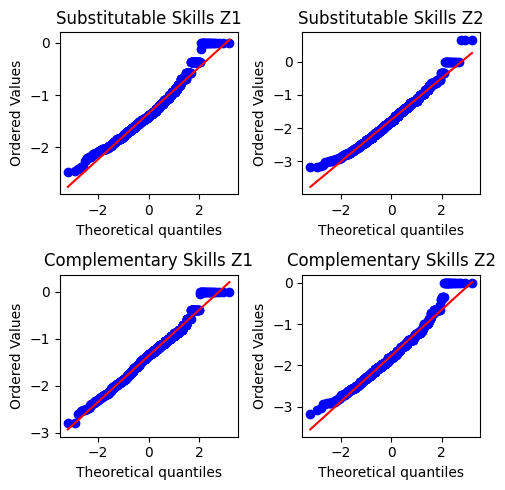

In [99]:
# normality checks imply cannot calculate parametric confidence intervals
# need to use bootstrap confidence intervals
fig, axes = plt.subplots(2, 2, figsize=(5, 5))
z_vars = ["SUBSTITUTE_Z1", "SUBSTITUTE_Z2", "COMPLEMENT_Z1", "COMPLEMENT_Z2"]
titles = ["Substitutable Skills Z1", "Substitutable Skills Z2", "Complementary Skills Z1", "Complementary Skills Z2"]
for i, ax in enumerate(axes.flatten()):
    stats.probplot(posts_df.sample(1000)[z_vars[i]], dist="norm", plot=ax)
    ax.set_title(titles[i])
    # perform Shapiro-Wilk test for normality
    stat, p = stats.shapiro(posts_df.sample(5000)[z_vars[i]])
    print(f"Shapiro-Wilk test for {z_vars[i]}: stat={stat:.4f}, p={p:.4f}")
plt.tight_layout()
plt.savefig("figures/zvar_qq_plots.png", dpi=300)

In [ ]:
# bootstrap ODR to fit a line in the ilr space
def odr_bootstrap(z1, z2):

    def f(B, x):
        return B[0]*x + B[1]

    # cannot perform ODR on the full dataset due to memory constraints
    indices = np.random.choice(np.arange(len(z1)), size=10_000, replace=True)

    # use linear regression to get parameter priors
    linreg = linregress(z1[indices], z2[indices])

    # this estimates the equation z2 = slope * z1 + intercept
    linear = odr.Model(f)
    # constant uncertainty weights reduces ODR to PCA
    data = odr.Data(z1[indices], z2[indices], we=1, wd=1)
    odr_model = odr.ODR(data, linear, beta0=linreg[:2])
    output = odr_model.run()

    # calculate p-value for slope
    # t_stat = output.beta[0] / output.sd_beta[0]
    # p_value = 2 * (1 - stats.t.cdf(np.abs(t_stat), df=len(z1)-2))
    # print(f"Slope p-value: {p_value}")
    
    slope, intercept = output.beta

    return slope, intercept

def inverse_logratio(z1, z2):
    
    # recover composition points from ilr coordinates
    x1 = np.exp(np.sqrt(2/3)*z1)
    x2 = np.exp(-(np.sqrt(1/6)*z1) + (1/np.sqrt(2))*z2)
    x3 = np.exp(-np.sqrt(1/6)*z1 - (1/np.sqrt(2))*z2)
    return np.array([x1, x2, x3]) / (x1 + x2 + x3)

def ilr_line_to_simplex(slope, intercept, t_arr):

    # uses fitted slope and intercept to get points on the ilr line
    X = []
    for t in t_arr:
        X.append(inverse_logratio(t, slope * t + intercept))
        
    return np.array(X)
    
def bootstrap_ilr_line_w_conf_intervals(z1, z2, other, rng, n, name, n_boot=100):

    # bootstrap the ilr line fit and plot with confidence intervals
    t_arr = np.linspace(rng[0], rng[1], n)
    X_boot = []
    for _ in range(n_boot):
        slope, intercept = odr_bootstrap(z1, z2)
        X = ilr_line_to_simplex(slope, intercept, t_arr)
        X_boot.append(X)
        
    X_boot = np.array(X_boot)
    assert np.allclose(X_boot.sum(axis=2), 1.0)

    # compute mean and 95% confidence intervals from bootstrap samples
    X_mean = X_boot.mean(axis=0)
    X_lower = np.percentile(X_boot, 2.5, axis=0)
    X_upper = np.percentile(X_boot, 97.5, axis=0)

    fig = go.Figure()
    fig.add_trace(
        go.Scatter(
            x=t_arr,
            y=X_mean[:,0],
            mode="lines",
            name="AI Skills",
            line=dict(color="green"),
        )
    )
    fig.add_trace(
        go.Scatter(
            x=np.concatenate([t_arr, t_arr[::-1]]),
            y=np.concatenate([X_lower[:,0], X_upper[:,0][::-1]]),
            fill='toself',
            fillcolor='rgba(0, 255, 0, 0.2)',
            line=dict(color='rgba(255,255,255,0)'),
            hoverinfo="skip",
            showlegend=False,
        )
    )
    fig.add_trace(
        go.Scatter(
            x=t_arr,
            y=X_mean[:,1],
            mode="lines",
            name=name,
            line=dict(color="red" if name == "Substitutable Skills" else "blue"),
        )
    )
    fig.add_trace(
        go.Scatter(
            x=np.concatenate([t_arr, t_arr[::-1]]),
            y=np.concatenate([X_lower[:,1], X_upper[:,1][::-1]]),
            fill='toself',
            fillcolor='rgba(255, 0, 0, 0.2)' if name == "Substitutable Skills" else 'rgba(0, 0, 255, 0.2)',
            line=dict(color='rgba(255,255,255,0)'),
            hoverinfo="skip",
            showlegend=False,
        )
    )
    fig.add_trace(
        go.Scatter(
            x=t_arr,
            y=X_mean[:,2],
            mode="lines",
            name="Other Skills",
            line=dict(color="black"),
        )
    )
    fig.add_trace(
        go.Scatter(
            x=np.concatenate([t_arr, t_arr[::-1]]),
            y=np.concatenate([X_lower[:,2], X_upper[:,2][::-1]]),
            fill='toself',
            fillcolor='rgba(0, 0, 0, 0.2)',
            line=dict(color='rgba(255,255,255,0)'),
            hoverinfo="skip",
            showlegend=False,
        )
    )
    
    # add region covering 5th to 95th percentile where most data lies
    percentile_small = np.percentile(other, 5)
    percentile_large = np.percentile(other, 95)

    idx_small = np.where(X_mean[:,2] <= percentile_small)[0]
    idx_large = np.where(X_mean[:,2] <= percentile_large)[0]

    idx_small = idx_small[0]
    idx_large = idx_large[0]

    fig.add_trace(
        go.Scatter(
            x=[t_arr[idx_large], t_arr[idx_large], t_arr[idx_small], t_arr[idx_small]],
            y=[0, 1, 1, 0],
            fill='toself',
            fillcolor='rgba(200, 200, 200, 0.3)',
            line=dict(color='rgba(255,255,255,0)'),
            hoverinfo="skip",
            showlegend=False,
        )
    )
    
    fig.update_layout(
        title=f"AI Skill Tradeoff: {name}",
        xaxis_title=None,
        yaxis_title="Proportion",
        template="plotly_white",
        width=600,
        height=400,
        yaxis_range=[0, 1],
        xaxis_showgrid=False,
        yaxis_showgrid=False,
        xaxis_showticklabels=False,  
        xaxis_zeroline=False,
        margin=dict(l=50, r=50, t=50, b=50),
        legend=dict(
            title=None,
            yanchor="top",
            y=1,
            xanchor="center",
            x=.5,
            bordercolor="Black",
            borderwidth=1,
            font=dict(size=10)
        )
    )
    name = "Substitutable Skills" if name == "Substitutable Skills" else "Complementary Skills"
    fig.write_image(f"figures/ilr_line_{name}.png", width=600, height=400, scale=2)
    fig.show()

posts_df["SUB_OTHER_PERC"] = posts_df["NON_AI_SUBSTITUTE_COUNT"] / (posts_df["SUBSTITUTE_COUNT"] + posts_df["NON_AI_SUBSTITUTE_COUNT"] + posts_df["AI_COUNT"])
bootstrap_ilr_line_w_conf_intervals(posts_df["SUBSTITUTE_Z1"].to_numpy(), posts_df["SUBSTITUTE_Z2"].to_numpy(), posts_df["SUB_OTHER_PERC"].to_numpy(), [-2, 2], 100, "Substitutable Skills")
posts_df["COMP_OTHER_PERC"] = posts_df["NON_AI_COMPLEMENT_COUNT"] / (posts_df["COMPLEMENT_COUNT"] + posts_df["NON_AI_COMPLEMENT_COUNT"] + posts_df["AI_COUNT"])
bootstrap_ilr_line_w_conf_intervals(posts_df["COMPLEMENT_Z1"].to_numpy(), posts_df["COMPLEMENT_Z2"].to_numpy(), posts_df["COMP_OTHER_PERC"].to_numpy(), [-2, 2], 100, "Complementary Skills")

# Internal Effects Analysis

In [ ]:
# map from variable names to display names
display_names = {
    "SUMMARY_REPORT": "Summary Report",
    "CUSTOMER_SERVICE": "Customer Service",
    "OFFICE_ADMIN": "Office Admin",
    "LANGUAGE_REVIEW": "Language Review",
    "SUBSTITUTE": "Substitute",
    "ANALYTICAL_THINKING": "Analytical Thinking",
    "DIGITAL_LITERACY": "Digital Literacy",
    "RESILIENCE": "Resilience",
    "TECHNICAL_PROFICIENCY": "Technical Proficiency",
    "ETHICS": "Ethics",
    "WORKING_OTHERS": "Working with Others",
    "SELF_EFFICIENCY": "Self Efficiency",
    "COMPLEMENT": "Complementary"
}

# same model for each skill group
def logit_regression(df, response): 
    return smf.logit(f"{response} ~ AI + MIN_YEARS_EXPERIENCE + C(MIN_EDULEVELS_NAME) + C(YEAR) + C({country[choice]['REGION']}) + C({country[choice]['INDUSTRY']}) + C({country[choice]['HIGH_OCC_NAME']})", data=posts_df).fit()

logit_models ={k: logit_regression(posts_df, k) for k in tqdm(display_names.keys(), total=len(display_names))}

  0%|          | 0/13 [00:00<?, ?it/s]

Optimization terminated successfully.
         Current function value: 0.127531
         Iterations 9


  8%|▊         | 1/13 [01:42<20:35, 102.92s/it]

Optimization terminated successfully.
         Current function value: 0.544454
         Iterations 6


 15%|█▌        | 2/13 [03:17<17:59, 98.16s/it] 

Optimization terminated successfully.
         Current function value: 0.135744
         Iterations 10


 23%|██▎       | 3/13 [05:08<17:17, 103.74s/it]

Optimization terminated successfully.
         Current function value: 0.296440
         Iterations 7


 31%|███       | 4/13 [06:45<15:12, 101.37s/it]

Optimization terminated successfully.
         Current function value: 0.603239
         Iterations 5


 38%|███▊      | 5/13 [08:24<13:21, 100.21s/it]

Optimization terminated successfully.
         Current function value: 0.533047
         Iterations 6


 46%|████▌     | 6/13 [10:01<11:35, 99.40s/it] 

Optimization terminated successfully.
         Current function value: 0.316473
         Iterations 7


 54%|█████▍    | 7/13 [12:13<10:59, 109.88s/it]

Optimization terminated successfully.
         Current function value: 0.145676
         Iterations 8


 62%|██████▏   | 8/13 [14:06<09:14, 110.84s/it]

Optimization terminated successfully.
         Current function value: 0.117578
         Iterations 9


 69%|██████▉   | 9/13 [16:08<07:37, 114.28s/it]

Optimization terminated successfully.
         Current function value: 0.204830
         Iterations 8


 77%|███████▋  | 10/13 [17:47<05:28, 109.62s/it]

Optimization terminated successfully.
         Current function value: 0.324779
         Iterations 7


 85%|████████▍ | 11/13 [19:24<03:31, 105.92s/it]

Optimization terminated successfully.
         Current function value: 0.087109
         Iterations 9


 92%|█████████▏| 12/13 [21:08<01:45, 105.37s/it]

Optimization terminated successfully.
         Current function value: 0.665163
         Iterations 5


100%|██████████| 13/13 [23:03<00:00, 106.45s/it]


In [144]:
# get 95% confidence interval for a variable in a model
def get_conf(model, variable):
    return model.conf_int(alpha=.05).reset_index().groupby("index").get_group(variable)[1].values[0] -  model.params[variable]

def model_summary_plot(models, responses, regressors, title, salary_model=False):
    
    table = summary_col(
        [models[r] for r in responses],
        regressor_order=regressors,
        stars=True,
        float_format='%0.2f',
        info_dict={
            'N':lambda x: "{0:d}".format(int(x.nobs)),
            'R2':lambda x: "{:.2f}".format(x.rsquared)
        }
    )
    
    fig = go.Figure()
    for res in responses:
        fig.add_trace(
            go.Scatter(
                x=[models[res].params["AI" if not salary_model else res]],
                y=[display_names[res]],
                mode='markers',
                marker=dict(size=8, color='red'),
                error_x=dict(
                    type='data',
                    array=[get_conf(models[res], "AI" if not salary_model else res)],
                    visible=True,
                    color='black'
                ),
                showlegend=False
            )
        )
        
    # print(table.as_latex())
        
    fig.update_layout(
        title=title,
        xaxis_title="Coefficient",
        template="plotly_white",
        xaxis_showgrid=False,
        yaxis_showgrid=False,
        margin=dict(l=50, r=50, t=50, b=50),
        xaxis_range=[-.3, .3] if salary_model else [-1, 1],
        width=400,
        height=300
    )
    
    model_type = "salary" if salary_model else "logit"
    group = "substitute" if "SUMMARY_REPORT" in responses else "complement"
    fig.write_image(f"figures/{model_type}_coefficients_{group}.png", width=400, height=300, scale=2)
    
    fig.show()

    return table, \
        {k: m.params[k if salary_model else "AI"] for k, m in models.items()}, \
        {k: get_conf(m, k if salary_model else "AI") for k, m in models.items()}

sub_responses = ["SUMMARY_REPORT", "LANGUAGE_REVIEW", "CUSTOMER_SERVICE", "OFFICE_ADMIN", "SUBSTITUTE"]
sub_logit_table, sub_logit_coefs, sub_logit_confs = model_summary_plot(
    logit_models, 
    sub_responses, 
    ["AI", "MIN_YEARS_EXPERIENCE", "BODY_LENGTH"],
    "Substitute Demand (% change for AI roles)"
)
comp_responses = ["ANALYTICAL_THINKING", "DIGITAL_LITERACY", "RESILIENCE", "TECHNICAL_PROFICIENCY", "ETHICS", "WORKING_OTHERS", "SELF_EFFICIENCY", "COMPLEMENT"]
comp_logit_table, comp_logit_coefs, comp_logit_confs = model_summary_plot(
    logit_models, 
    comp_responses, 
    ["AI", "MIN_YEARS_EXPERIENCE", "BODY_LENGTH"], 
    "Complement Demand (% change for AI roles)"
)

In [146]:
# same model for each skill group
def ols_regression(df, response): 
    return smf.ols(f"LOG_SALARY ~ {response} + MIN_YEARS_EXPERIENCE + MIN_YEARS_EXPERIENCE + MIN_YEARS_EXPERIENCE_SQ + C(MIN_EDULEVELS_NAME) + C(YEAR) + C({country[choice]['REGION']}) + C({country[choice]['INDUSTRY']}) + C({country[choice]['HIGH_OCC_NAME']})", data=df).fit()

# create experience squared for mincer wage equation
posts_df["MIN_YEARS_EXPERIENCE_SQ"] = posts_df["MIN_YEARS_EXPERIENCE"] ** 2
ols_models ={k: ols_regression(posts_df[posts_df["AI"] == 1], k) for k in tqdm(display_names.keys(), total=len(display_names))}

100%|██████████| 13/13 [00:06<00:00,  2.11it/s]


In [150]:
sub_ols_table, sub_ols_coefs, sub_ols_confs = model_summary_plot(
    ols_models, 
    sub_responses, 
    sub_responses + ["MIN_YEARS_EXPERIENCE", "BODY_LENGTH"], 
    "Wage Premium in AI Roles (substitute)", 
    salary_model=True
)
comp_ols_table, comp_ols_coefs, comp_ols_confs = model_summary_plot(
    ols_models, 
    comp_responses, 
    comp_responses + ["MIN_YEARS_EXPERIENCE", "BODY_LENGTH"], 
    "Wage Premium in AI Roles (complement)", 
    salary_model=True
)

## Create External Effects Data

In [154]:
def create_external_effects_df(df, group_vars):

    df2 = df \
        .groupby(group_vars) \
        .agg({
            "AI": "mean",
            "ID": "count",
        }).rename(
            columns={
                "ID": "COUNT"
            }
        )

    nonai_df2 = df[df["AI"] == 0] \
        .groupby(group_vars) \
        .agg({
            "SUBSTITUTE": "mean",
            "COMPLEMENT": "mean",
        }).rename(
            columns={
                "SUBSTITUTE": "NONAI_SUBSTITUTE",
                "COMPLEMENT": "NONAI_COMPLEMENT",
            }
        )
        
    # remerging AI and non-AI company dataframes
    return df2 \
        .join(
            nonai_df2,
            on=group_vars,
            how="left"
        ) \
        .fillna(
            {
                "NONAI_SUBSTITUTE": 0,
                "NONAI_COMPLEMENT": 0,
            }
        ).reset_index()

In [156]:
# create company data for external effects
company_counts = posts_df.value_counts(["COMPANY", "YEAR"])
comps = company_counts[company_counts >= 10]
comps = [x[0] for x in comps.index.tolist()]
comps = pd.Series(comps).value_counts()
valid_comps = comps[comps == 6].index.tolist()

company_df = posts_df[
    (~posts_df["COMPANY_IS_STAFFING"]) &
    (posts_df["COMPANY"] != "0") &
    (posts_df["COMPANY"].isin(valid_comps))
].reset_index(drop=True)
company_group_vars = ["COMPANY", "COMPANY_NAME", country[choice]["INDUSTRY"], "YEAR"]

company_df2 = create_external_effects_df(company_df, company_group_vars)
company_df2.to_csv("processed_data/company_data.csv", index=False)

# create industry data for external effects
industry_df = posts_df[posts_df[country[choice]["INDUSTRY"]] != "Unclassified Industry"]
industry_group_vars = [country[choice]["INDUSTRY"], "YEAR"]
industry_df2 = create_external_effects_df(industry_df, industry_group_vars)
industry_df2.to_csv("processed_data/industry_data.csv", index=False)

# create state level data for external effects
state_df = posts_df[posts_df[country[choice]["REGION"]] != "Unclassified Region"]
state_group_vars = [country[choice]["REGION"], "YEAR"]
state_df2 = create_external_effects_df(state_df, state_group_vars)
state_df2.to_csv("processed_data/state_data.csv", index=False)